## Import the necessary dependencies

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as cimg
%matplotlib inline

## Visualizing function

In [2]:
def visualize_images_in_pair(firstImgs,secondImgs,
                             firstTitle=" ", secondTitle=" ",
                             figsize=(10,30)):
    # Setup plot
    plt.figure(1,figsize=figsize)
    idx = 0
    plt_cols = 2
    plt_rows = len(rawImgs)/plt_cols * 2 + 1

    for img, correctedImg in zip(firstImgs,secondImgs):
        #plot image
        plt.subplot(plt_rows, plt_cols, idx+1)
        plt.imshow(img.astype(np.uint8),cmap='gray')
        plt.title(firstTitle + ' {}'.format(idx/2),size=15)
        plt.subplot(plt_rows, plt_cols, idx+2)
        plt.imshow(correctedImg.astype(np.uint8),cmap='gray')
        plt.title(secondTitle + ' {}'.format(idx/2),size=15)
        idx += 2

## Retrieve the path of calibrating and testing images

In [3]:
# Make a list of test images
testImgFolder = './test_images'
testImgPaths = glob.glob(testImgFolder + '/*.jpg')

In [4]:
# Make a list of calibration images
calibratingImgFolder = './camera_cal'
calibratingImgPaths = glob.glob(calibratingImgFolder + '/calibration*.jpg')

## Define the functions of calibration

In [5]:
def calibrate_camera(calibratingImgPaths, gridSize = (6,9), visualization=True):
    '''calibrate the camera
        input: calibratingImgPaths: list of paths to the calibrating images
               gridSize : number of corners in rows and columns of the chessboard
               visualization: if true, the detected chessboard images will be shown
        output: ret, mtx, dist, rvecs, tvecs, imgSize
    '''
    #define number of rows and column of the chessboard
    n_rows, n_cols = gridSize
    
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((n_rows*n_cols,3), np.float32)
    objp[:,:2] = np.mgrid[0:n_cols,0:n_rows].T.reshape(-1,2)
    
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    imgW = None
    imgH = None
    
    # Setup plot
    if (visualization):
        plt.figure(1,figsize=(15,20))
        idx = 0
        plt_cols = 3
        plt_rows = len(calibratingImgPaths)/plt_cols + 1
        
    # Step through the list and search for chessboard corners
    for fname in calibratingImgPaths:
        img = cimg.imread(fname)
        
        if imgW is None and imgH is None:
            imgH = img.shape[0]
            imgW = img.shape[1]
        elif (imgH != img.shape[0]) or (imgW != img.shape[1]):
            assert "The size of calibrated images are inconsistent!"
            
        gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (n_cols,n_rows),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            if (visualization):
                cv2.drawChessboardCorners(img, (n_cols,n_rows), corners, ret)
                plt.subplot(plt_rows, plt_cols, idx+1)
                plt.imshow(img.astype(np.uint8),cmap='gray')
                idx += 1
    
    imgSize = (imgH,imgW)
    #compute the camera matrix (mtx) and distortion coefficients (dist):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, imgSize, None, None)
    return (ret, mtx, dist, rvecs, tvecs, imgSize)

def undistort_image(img, mtx, distCoeff):
    '''undistort the images given the image, camera matrix and distortion coefficient
        input: img: input image
               mtx: camera matrix
               distCoeff: distortion coefficients
        output: return list of undistorted images
    '''
    returnedImg = cv2.undistort(img, mtx, distCoeff, None, mtx)
    return returnedImg

## Step 1: Calibrate the camera:

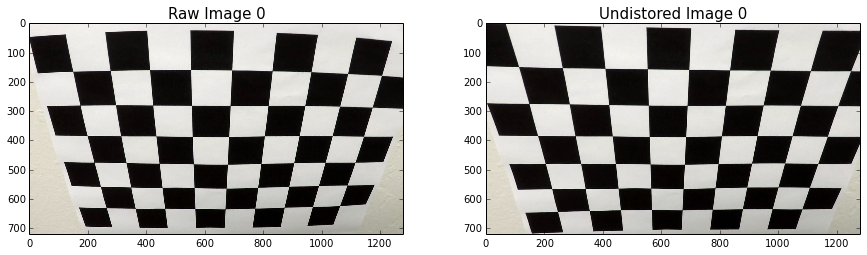

In [6]:
#Calibrate the camera
_,mtx,distCoeff,_,_,imgSize = calibrate_camera(calibratingImgPaths, visualization = False)

#Read the raw testing images
rawImgs = [cimg.imread(fname) for fname in testImgPaths]

#undistored all of them
correctedImgs = [undistort_image(img,mtx,distCoeff) for img in rawImgs]

########################### Visuzualization #####################################
#Read the raw images
visualizedRawImgs = [cimg.imread(fname) for fname in calibratingImgPaths[7:8]]

#undistored all of them
visualizedCorrectedImgs = [undistort_image(img,mtx,distCoeff) for img in visualizedRawImgs]

#visualize the images
visualize_images_in_pair(visualizedRawImgs,visualizedCorrectedImgs,
                         firstTitle="Raw Image",secondTitle="Undistored Image",
                         figsize=(15,40))
########################### End of Visuzualization################################

## Step 2: Find laneline pixels by color&gradient thesholding within a predefined region of interest

### a. Define a region of interest

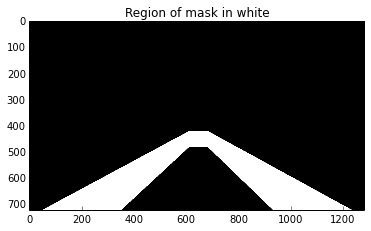

In [7]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

#define the masking region of the laneline
left_bottom = (50, 720)
right_bottom = (1230, 720)
apex1 = (610, 420)
apex2 = (680, apex1[1])
inner_left_bottom = (left_bottom[0] + 300, 720)
inner_right_bottom = (right_bottom[0] - 300 , 720)
inner_apex1 = (680,apex1[1]+60)
inner_apex2 = (610,inner_apex1[1])
masking_vertice = np.array([[left_bottom, apex1, apex2, right_bottom, \
                          inner_right_bottom, inner_apex1, inner_apex2, inner_left_bottom]], dtype=np.int32)

visualizedMask = np.zeros([720,1280],dtype=np.uint8)
cv2.fillPoly(visualizedMask,masking_vertice,color=(1))
plt.imshow(visualizedMask,cmap='gray')
plt.title("Region of mask in white")

### b. Color&gradient thresholding

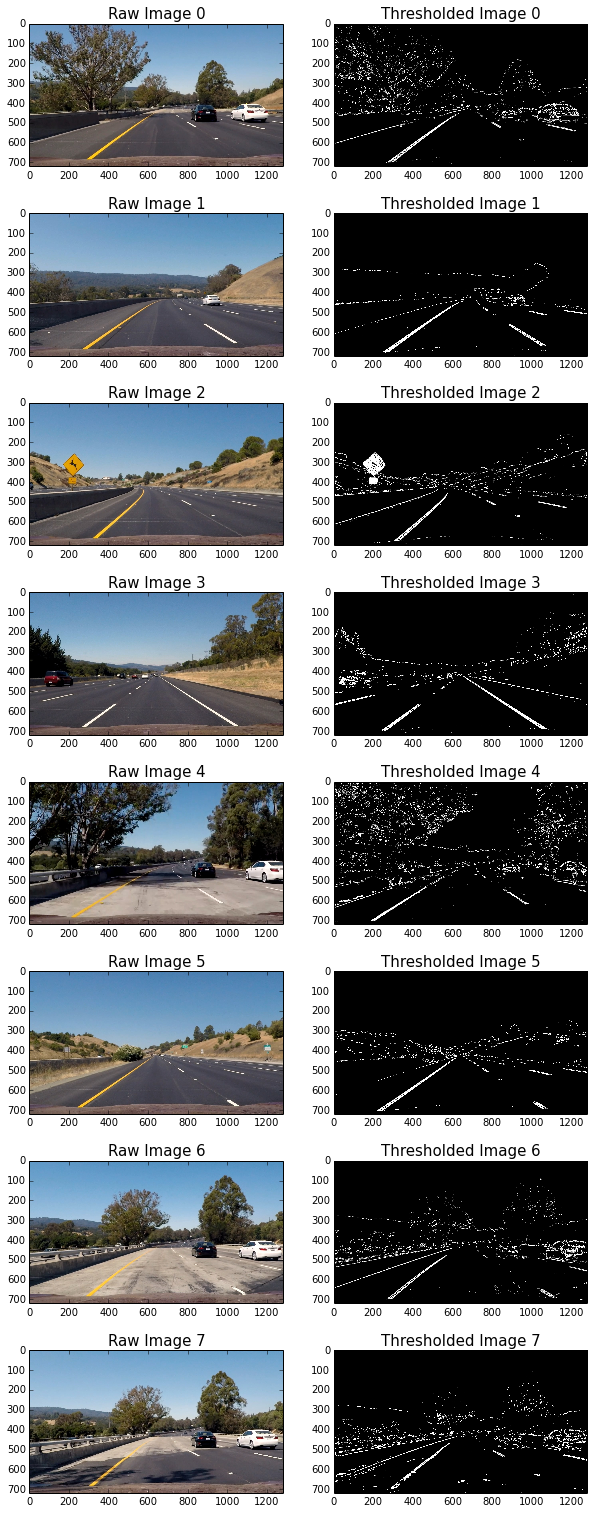

In [8]:
# Calculate directional gradient
def abs_sobel_thresh(gray, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Apply x or y gradient
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute values
    sobel = np.absolute(sobel)
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*sobel/np.max(sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # Return the result
    return binary_output

# Calculate gradient magnitude
def mag_threshold(sobelx, sobely, thresh=(0, 255)):
    # Calculate the gradient magnitude
    sobel = np.sqrt(sobelx ** 2 + sobely ** 2)
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*sobel/np.max(sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # Return the result
    return binary_output

# Calculate gradient direction
def dir_threshold(sobelx, sobely,thresh=(0, np.pi/2)):
    #Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx) + 1e-6
    abs_sobely = np.absolute(sobely) 
    #Use np.arctan(abs_sobelx/abs_sobely) to calculate the direction of the gradient 
    dir_sobel = np.arctan(abs_sobely/abs_sobelx)
    #Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(dir_sobel)
    binary_output[(dir_sobel >= thresh[0]) & (dir_sobel <= thresh[1])] = 1
    #Return this mask as your binary_output image
    return binary_output

#Use color transforms, gradients, etc., to create a thresholded binary image.
def colorAndGradientThreshold(img, s_thresh=(160, 255), 
                              sx_thresh=(10, 255), sy_thresh=(60, 255),
                              mag_thresh=(40, 255), dir_thresh=(.65, 1.05)
                             ):
    # Gaussian Blur
    kernel_size = 3
    blurred_img = cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(blurred_img, cv2.COLOR_RGB2HLS)
    s = hls[:,:,2]
    # Convert to gray space
    gray = cv2.cvtColor(blurred_img, cv2.COLOR_RGB2GRAY)
    # Define sobel kernel size
    ksize = 3
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh=sx_thresh)
    grady = abs_sobel_thresh(gray, orient='y', sobel_kernel=ksize, thresh=sy_thresh)
    mag_binary = mag_threshold(gradx, grady, thresh=mag_thresh)
    dir_binary = dir_threshold(gradx, grady, thresh=dir_thresh)
    # Combine all the thresholding information
    combined = np.zeros(dir_binary.shape[0:2],dtype=np.uint8)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 255
    # Threshold color channel
    s_binary = np.zeros(combined.shape[0:2],dtype=np.uint8)
    s_binary[(s > s_thresh[0]) & (s < s_thresh[1])] = 255
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(combined), combined, s_binary))
    
    binary = np.zeros(combined.shape[0:2],dtype=np.uint8)
    binary[(s_binary > 0) | (combined > 0)] = 255
    
    return color_binary, binary

binaryImgs = []
for correctedImg in correctedImgs:
    _, binaryTmp = colorAndGradientThreshold(correctedImg,s_thresh=(160, 255), 
                                            sx_thresh=(10, 255), sy_thresh=(50, 255),
                                            mag_thresh=(40, 255), dir_thresh=(.60, 1.1))
    binaryImgs.append(binaryTmp)

#visualize the images
visualize_images_in_pair(rawImgs,binaryImgs,
                         firstTitle="Raw Image",secondTitle="Thresholded Image",
                         figsize=(10,30))


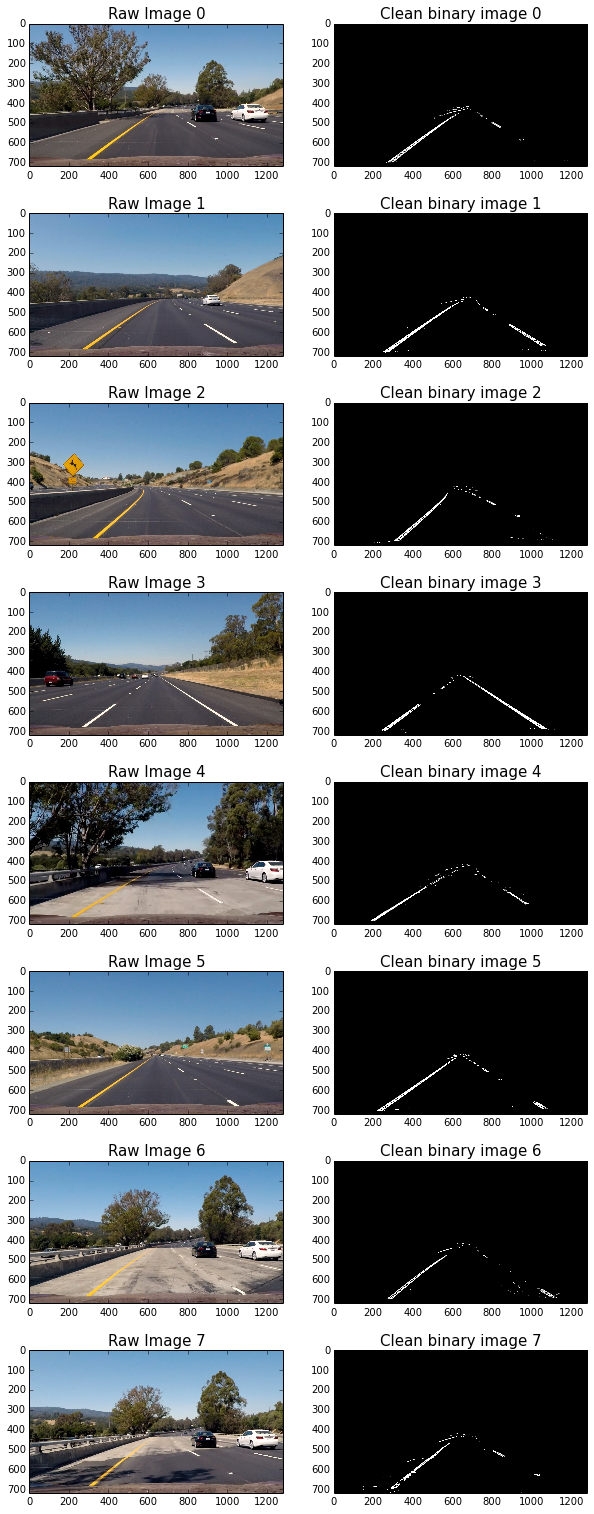

In [9]:
def detectLanelinePixels(img, mask = masking_vertice):
    _, binaryImage = colorAndGradientThreshold(img,s_thresh=(160, 255), 
                                            sx_thresh=(10, 255), sy_thresh=(50, 255),
                                            mag_thresh=(40, 255), dir_thresh=(.60, 1.1))
    return region_of_interest(binaryImage,mask)


lanelinePixelImgs = [detectLanelinePixels(correctedImg) for correctedImg in correctedImgs]

#visualize the images
visualize_images_in_pair(rawImgs,lanelinePixelImgs,
                         firstTitle="Raw Image",secondTitle="Clean binary image",
                         figsize=(10,30))

## Step 3: Transform the edge images to birdeye view by a predefinef perspective transformation matrix

src = [[[  220.   720.]
  [  585.   460.]
  [  700.   460.]
  [ 1060.   720.]]]
dist = [[[ 300.  720.]
  [ 300.    0.]
  [ 980.    0.]
  [ 980.  720.]]]


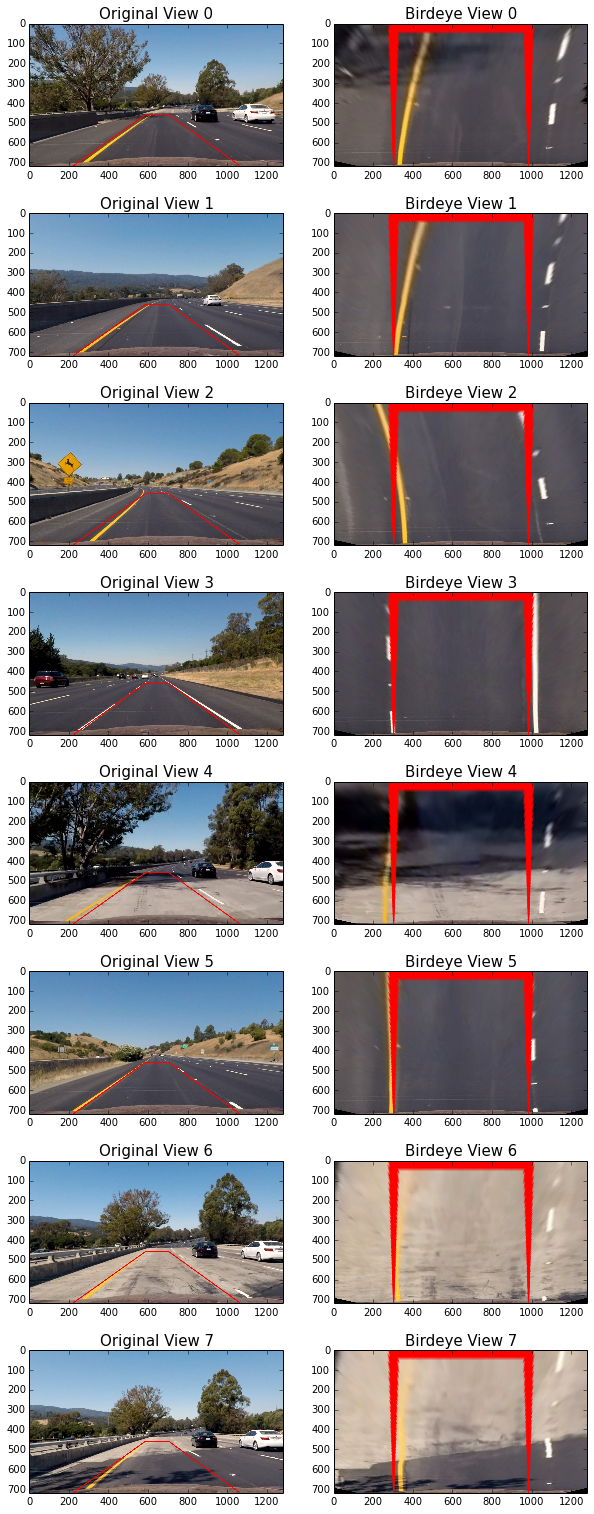

In [10]:
#define the source coordinates
left_bottom = (220, 720)
right_bottom = (1280 - left_bottom[0], 720)
apex1 = (585, 460)
apex2 = (700, apex1[1])
birdeye_roi_src = np.array([[left_bottom, apex1, apex2, right_bottom,]], dtype=np.float32)
print "src = {}".format(birdeye_roi_src)

#define the destination coordinates
left_bottom = (300, 720)
right_bottom = (1280 - left_bottom[0], 720)
left_top = (left_bottom[0], 0)
right_top = (right_bottom[0], 0)
birdeye_roi_dst = np.array([[left_bottom, left_top, right_top, right_bottom,]], dtype=np.float32)
print "dist = {}".format(birdeye_roi_dst)

#define the forward and backward transforming matrix
perspectiveTransformMatrix = cv2.getPerspectiveTransform(birdeye_roi_src, birdeye_roi_dst)
invPerspectiveTransformMatrix = cv2.getPerspectiveTransform(birdeye_roi_dst, birdeye_roi_src)

def warp_forward(inputImg):
    return cv2.warpPerspective(inputImg,perspectiveTransformMatrix, \
                              (inputImg.shape[1],inputImg.shape[0]), flags=cv2.INTER_LINEAR)
def warp_backward(inputImg):
    return cv2.warpPerspective(inputImg,invPerspectiveTransformMatrix, \
                              (inputImg.shape[1],inputImg.shape[0]), flags=cv2.INTER_LINEAR)

#visualize the raw images in birdeye view
originalViews = [ cv2.polylines(img.copy(),birdeye_roi_src.astype(np.int32),isClosed=True,color=(255,0,0),thickness=3) 
                  for img in correctedImgs]
birdeyeViews = [ warp_forward(img) for img in originalViews]
visualize_images_in_pair(originalViews,birdeyeViews,"Original View", "Birdeye View")

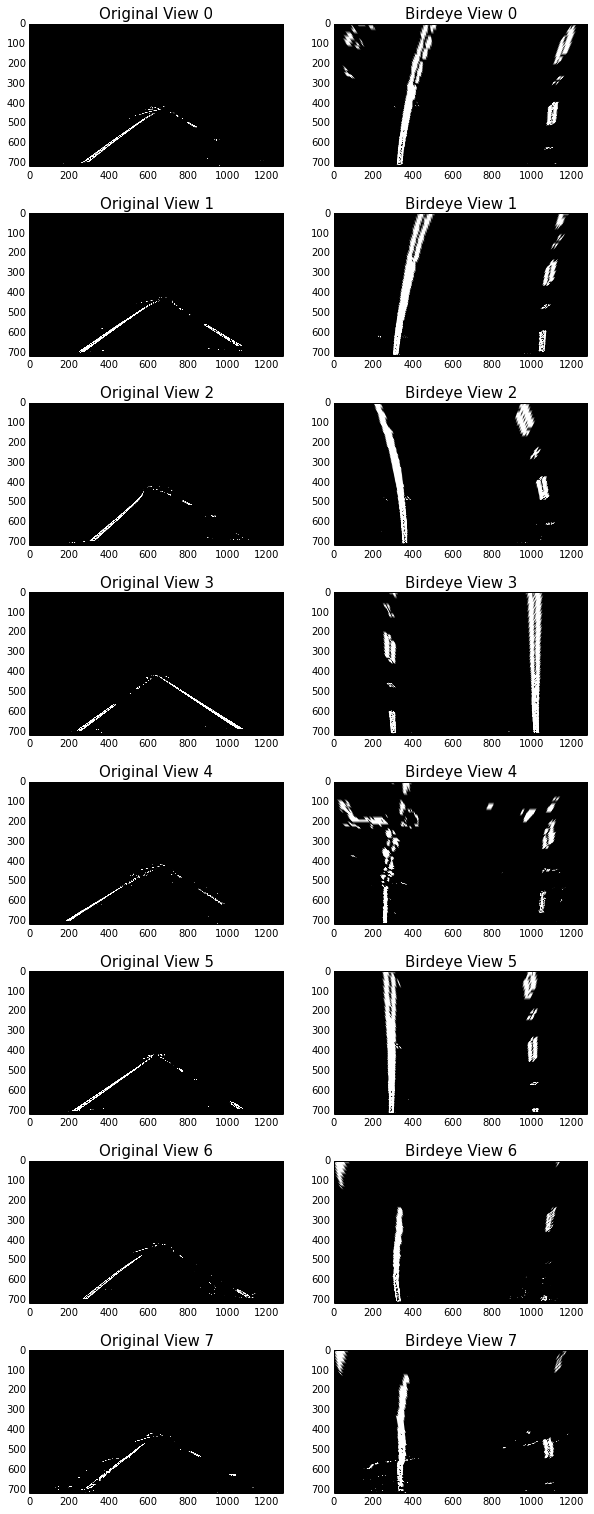

In [11]:
#visualize the binary images in birdeye view
lanelinePixelImgs_in_birdeyeViews = [warp_forward(img) for img in lanelinePixelImgs]
visualize_images_in_pair(lanelinePixelImgs,lanelinePixelImgs_in_birdeyeViews,"Original View", "Birdeye View")

## Step4: Extract the pixels belong to the left and right lanelines, then fit the 2-order curve to the left and right laneline 

In [12]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x,y values of the last n fits of the line
        self.recent_xyfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

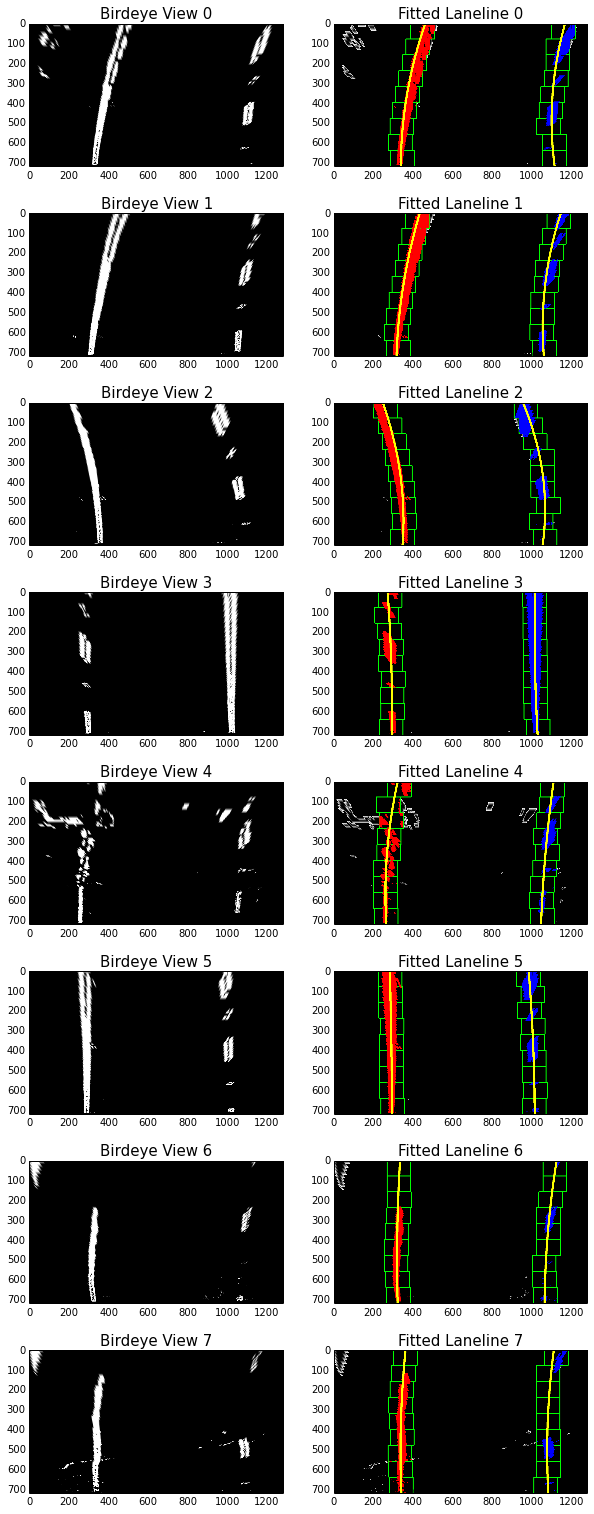

In [13]:
def fitLaneLine(binary_warped, returnVisualization=False):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 60
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Create empty mask of left and right lanes
    left_lane = np.zeros_like(binary_warped)
    right_lane = np.zeros_like(binary_warped)
    
    # Create an output image to draw on and  visualize the result
    if returnVisualization:
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    else:
        out_img = None
        
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        if returnVisualization:
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 3) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 3) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        if returnVisualization:
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
        #Creating the mask
        left_lane[win_y_low:win_y_high+1,win_xleft_low:win_xleft_high+1] = 1
        right_lane[win_y_low:win_y_high+1,win_xright_low:win_xright_high+1] = 1
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    if returnVisualization:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
        
    leftLaneline = Line()
    leftLaneline.allx = nonzerox[left_lane_inds]
    leftLaneline.ally = nonzeroy[left_lane_inds]
    
    rightLaneline = Line()
    rightLaneline.allx = nonzerox[right_lane_inds]
    rightLaneline.ally = nonzeroy[right_lane_inds]

    # Extract left and right line pixel positions
    leftLanePixelPos = np.where(left_lane > 0)
    leftx = leftLanePixelPos[1]
    lefty = leftLanePixelPos[0]
    
    rightLanePixelPos = np.where(right_lane > 0)
    rightx = rightLanePixelPos[1]
    righty = rightLanePixelPos[0]

    # Fit a second order polynomial to each
    leftLaneline.current_fit = np.polyfit(lefty, leftx, 2)
    rightLaneline.current_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    leftLaneline.recent_xyfitted = np.vstack(((leftLaneline.current_fit[0]*ploty**2 + \
                                   leftLaneline.current_fit[1]*ploty + \
                                   leftLaneline.current_fit[2]),ploty)).transpose()
    rightLaneline.recent_xyfitted =   np.vstack(((rightLaneline.current_fit[0]*ploty**2 + \
                                     rightLaneline.current_fit[1]*ploty + \
                                     rightLaneline.current_fit[2]),ploty)).transpose()
    
    if returnVisualization:
        out_img[leftLaneline.ally, leftLaneline.allx] = [255, 0, 0]
        out_img[rightLaneline.ally, rightLaneline.allx] = [0, 0, 255]
        cv2.polylines(out_img,np.int32([leftLaneline.recent_xyfitted]),isClosed=False,color=(255,255,0),thickness=10) 
        cv2.polylines(out_img,np.int32([rightLaneline.recent_xyfitted]),isClosed=False,color=(255,255,0),thickness=10)
        

    
    return leftLaneline, rightLaneline, out_img

leftLaneline = [] 
rightLaneline = []
visualLaneline = []
for img in lanelinePixelImgs_in_birdeyeViews:
    left, right, visual = fitLaneLine(img, True)
    leftLaneline.append(left)
    rightLaneline.append(right)
    visualLaneline.append(visual)
    
visualize_images_in_pair(lanelinePixelImgs_in_birdeyeViews,visualLaneline,"Birdeye View", "Fitted Laneline")

In [14]:
def compute_curvature(line):
    '''Compute the curvature of the line'''
    # Define y-value where we want radius of curvature
    yvals = np.float32(line.recent_xyfitted[:,1])
    fitx = np.float32(line.recent_xyfitted[:,0])
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30./720. # meters per pixel in y dimension
    xm_per_pix = 3.7/840. # meteres per pixel in x dimension
    fit_cr = np.polyfit(yvals*ym_per_pix, fitx*xm_per_pix, 2)
    
    line.radius_of_curvature = np.mean(((1. + (2.*fit_cr[0]*yvals + fit_cr[1])**2)**1.5) \
                                 /np.absolute(2.*fit_cr[0]))
    return line.radius_of_curvature

def compute_position(leftLaneline, rightLaneLine):
    '''Find the position of the car from the center'''

    leftX = leftLaneline.recent_xyfitted[-1,0]
    rightX = rightLaneLine.recent_xyfitted[-1,0]
    
    car_center_x = 640. #at the middle of the image
    lane_center = (leftX + rightX)/2.
    # Define conversions in x and y from pixels space to meters
    xm_per_pix = 3.7/840. # meteres per pixel in x dimension    
    return (car_center_x - lane_center)*xm_per_pix

def compute_distance_of_left_right_laneline(leftLaneline, rightLaneLine):
    '''Find the distance of left and right laneline'''
    leftX = leftLaneline.recent_xyfitted[-1,0]
    rightX = rightLaneLine.recent_xyfitted[-1,0]
    # Define conversions in x and y from pixels space to meters
    xm_per_pix = 3.7/840. # meteres per pixel in x dimension    
    return (rightX - leftX)*xm_per_pix

left_curvature = [compute_curvature(line) for line in leftLaneline]
right_curvature = [compute_curvature(line) for line in rightLaneline]
car_pos = [compute_position(left,right) for left,right in zip(leftLaneline,rightLaneline)]
lanelineDistance = [compute_distance_of_left_right_laneline(left,right) for left,right in zip(leftLaneline,rightLaneline)]
print np.array(zip(left_curvature,right_curvature))
print car_pos
print lanelineDistance
print leftLaneline[6].current_fit[1],rightLaneline[6].current_fit[1]

[[  1128.57226562   1083.56750488]
 [  1279.95703125   1078.29785156]
 [  1067.17565918   1079.35656738]
 [  3265.17504883   3647.48046875]
 [  1254.64465332   2905.96118164]
 [ 15810.59472656   3638.20483398]
 [  3348.84106445   1978.34753418]
 [  2118.80834961   1657.95117188]]
[-0.37178026567409517, -0.20471007982761202, -0.25811008405947272, -0.083217925601398665, -0.060175712821825225, -0.053920662445273874, -0.22512025094733948, -0.30708077776221498]
[3.4111081800812344, 3.2687035416157477, 3.1092828260109782, 3.2359689830766634, 3.4339275576442732, 3.1632909440265329, 3.2631989700117874, 3.262208054549006]
-0.0603698643987 -0.161078713213


In [15]:
#sanity check
def check_distance(leftLane,rightLane, lowThreshold=3.5, highThreshold=4.5):
    '''
    This function checks if the distance of the 2 lanes r 
    between lowThreshold and highThreshold meters
    '''
    dist = compute_distance_of_left_right_laneline(leftLane,rightLane)
    if dist < lowThreshold and dist > highThreshold:
        return True
    else:
        return False
    
def check_curvature(lane0,lane1,threshold=100.):
    if np.abs(lane0.radius_of_curvature - lane1.radius_of_curvature) < threshold:
        return True
    else:
        return False
    
def check_parallelism(lane0,lane1,threshold=0.1):
    if np.abs(lane0.current_fit[1] - lane1.current_fit[1]) < threshold:
        return True
    else:
        return False
    

uint8 (720, 1280, 3)


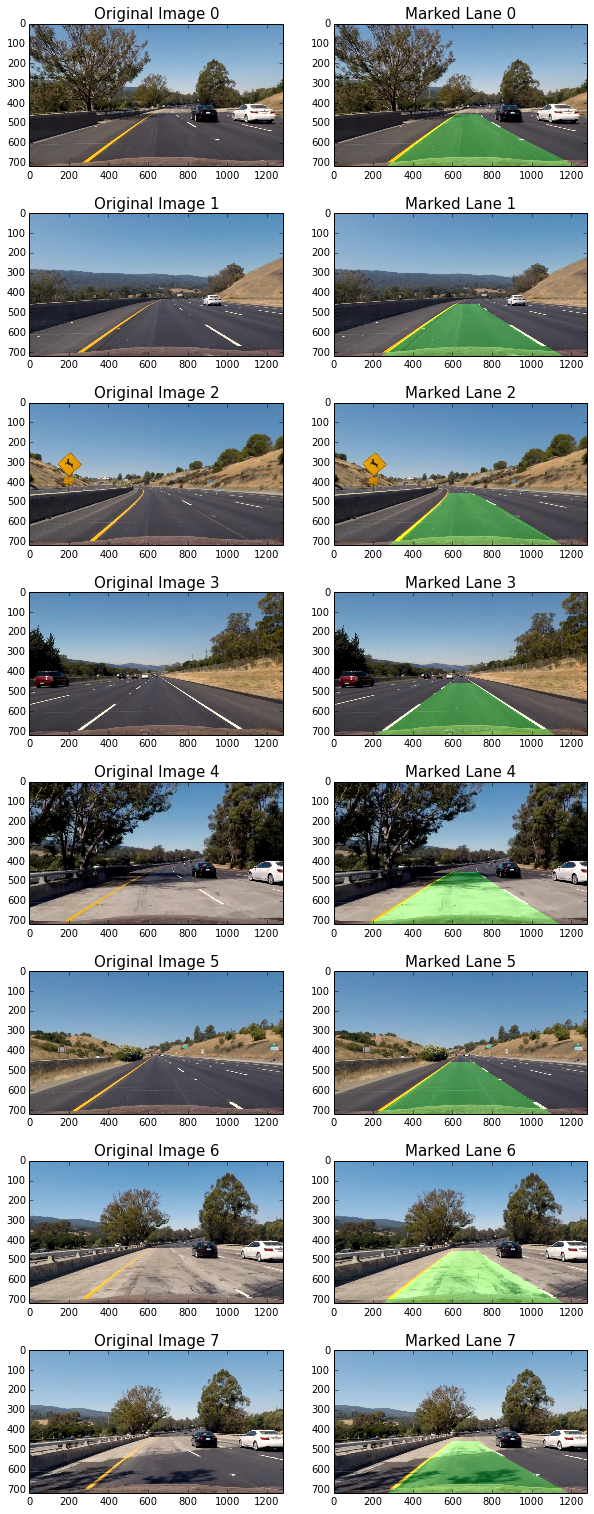

In [16]:
def drawRegionOfTheLane(img, leftLaneline, rightLaneLine, invPerspectiveTransformMatrix):
    # Create an image to draw the lines on
    color_warp = np.zeros_like(img)
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = leftLaneline.recent_xyfitted
    pts_right = np.flipud(rightLaneLine.recent_xyfitted)
    pts = np.vstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, invPerspectiveTransformMatrix, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    return result

detectedLaneImages = [ drawRegionOfTheLane(correctedImgs[idx],leftLaneline[idx],rightLaneline[idx], invPerspectiveTransformMatrix)
                     for idx in xrange(len(correctedImgs))]
print detectedLaneImages[0].dtype, detectedLaneImages[0].shape
visualize_images_in_pair(correctedImgs,detectedLaneImages,"Original Image", "Marked Lane")

In [17]:
# This function will color the image
# Input: Original image
# Output: Original image with colored lane region
#global leftLane, rightLane
globalLeftLane = None 
globalRightLane = None
def process_image(image, leftLane = globalLeftLane,rightLane = globalRightLane):
    # Correct image
    correctedImg = undistort_image(image,mtx,distCoeff)
    
    #detect pixel belongs to the lane line
    laneLinePixels = detectLanelinePixels(correctedImg)
    
    # Warp the image to birdeye view
    birdeye = cv2.warpPerspective(laneLinePixels,perspectiveTransformMatrix,
                                  (image.shape[1],image.shape[0]), flags=cv2.INTER_LINEAR) 
    
    # Find the lines fitting to left and right lanes
    newleftLane, newrightLane, _ = fitLaneLine(birdeye, False)
    
    #Find the curvature of the landline
    compute_curvature(newleftLane)
    compute_curvature(newrightLane)
    
    #peforms sanity check
    shouldUseSanityCheck = True
    if shouldUseSanityCheck:
        if leftLane is None and rightLane is None:
            leftLane = newleftLane
            rightLane = newrightLane
        elif (check_distance(newleftLane,newrightLane) and check_parallelism(newleftLane,newrightLane)):
            if check_curvature(leftLane,newleftLane):
                leftLane = newleftLane
            if check_curvature(rightLane,newrightLane):
                rightLane = newrightLane
    else:
        leftLane = newleftLane
        rightLane = newrightLane
        
    message = "The radius of curvature = {:.1f}(m)".format(leftLane.radius_of_curvature)
    cv2.putText(correctedImg,message,(10,50), cv2.FONT_HERSHEY_SIMPLEX, 1.5,(255,255,255),2,cv2.LINE_AA)
    
    #Find car position with respect to center of the lane
    car_position = compute_position(leftLane,rightLane)
    if (car_position > 0):
        message = "The vehicle is {:.3f} right of the center".format(car_position)
    else:
        message = "The vehicle is {:.3f}m left of the center".format(-car_position)
        
    cv2.putText(correctedImg,message,(10,100), cv2.FONT_HERSHEY_SIMPLEX, 1.5,(255,255,255),2,cv2.LINE_AA)
    
    # Return the original image with colored region
    outImg = drawRegionOfTheLane(correctedImg,leftLane,rightLane, invPerspectiveTransformMatrix)

    return outImg

# Video Processing

In [18]:
### Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
white_output = 'detected_laneline_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video detected_laneline_video.mp4
[MoviePy] Writing video detected_laneline_video.mp4


100%|█████████▉| 1260/1261 [06:21<00:00,  3.24it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: detected_laneline_video.mp4 

CPU times: user 7min 14s, sys: 4.18 s, total: 7min 18s
Wall time: 6min 23s


In [19]:
from IPython.display import HTML
HTML("""
<video width="1024" height="576" controls>
  <source src="{0}">
</video>
""".format(white_output))